In [1]:
# ======================================================
# 0. IMPORTS & GLOBAL SETTINGS
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
sns.set(style="whitegrid")

# %matplotlib inline   # (Uncomment in Jupyter if needed)

# ======================================================
# 1. LOAD DATA
# ======================================================
file_path = "/kaggle/input/income-case-study/income_case_study.csv"

df = pd.read_csv(file_path, sep=";")
# Dikkat: dosya ; ile ayrılmış
df = pd.read_csv(file_path, sep=";")




In [2]:
print(df.columns.tolist())


['age', 'workclass', 'education_level', 'education-num', 'marital-status', 'Name', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


In [3]:

#  Handle missing feature values
if "age" in df.columns:
    df["age_missing_flag"] = df["age"].isna().astype("int8")
    df["age"] = df["age"].fillna(df["age"].median()).astype("int64")

# education_num: median imputation + int
if "education-num" in df.columns:
    df["edu_num_missing_flag"] = df["education-num"].isna().astype("int8")
    df["education-num"] = (
        df["education-num"]
          .fillna(df["education-num"].median())
          .astype("int64")
    )
    

# education_level: fill missing with 'Unknown'
if "education_level" in df.columns:
    df["education_level"] = df["education_level"].fillna("Unknown")

In [4]:
import numpy as np
import pandas as pd

df_model = df.copy()

# Strip spaces from string cols
str_cols = df_model.select_dtypes(include="object").columns
df_model[str_cols] = df_model[str_cols].apply(lambda s: s.str.strip())

# ----- target -----
df_model = df_model[~df_model["income"].isna()].copy()
df_model["income_high"] = (df_model["income"] == ">50K").astype(int)

# Drop leakage
df_model = df_model.drop(columns=["Name"])

# ----- age features -----
age_bins   = [0, 25, 35, 45, 55, 65, 120]
age_labels = ["<25", "25-34", "35-44", "45-54", "55-64", "65+"]
df_model["age_group"] = pd.cut(df_model["age"], bins=age_bins, labels=age_labels, right=False)

# ----- hours features -----
hours_bins   = [0, 35, 41, 46, 61, 200]
hours_labels = ["<35", "35-40", "41-45", "46-60", "60+"]
df_model["hours_group"] = pd.cut(df_model["hours-per-week"], bins=hours_bins,
                                 labels=hours_labels, right=False)
df_model["long_hours_flag"] = (df_model["hours-per-week"] >= 46).astype(int)

# ----- education features -----
edu_order = [
    "Preschool","1st-4th","5th-6th","7th-8th","9th","10th","11th","12th",
    "HS-grad","Some-college","Assoc-voc","Assoc-acdm",
    "Bachelors","Masters","Prof-school","Doctorate"
]
edu_map = {edu: i for i, edu in enumerate(edu_order)}
df_model["education_level"] = df_model["education_level"].fillna("Unknown")
df_model["education_score"] = df_model["education_level"].map(edu_map).fillna(-1)


high_edu_levels = {"Bachelors","Masters","Prof-school","Doctorate"}
df_model["high_education_flag"] = df_model["education_level"].isin(high_edu_levels).astype(int)
df_model.drop(columns=["education_level"], inplace=True)



# ----- capital features -----
df_model["has_capital_gain"] = (df_model["capital-gain"].astype(int) > 0).astype(int)
df_model["has_capital_loss"] = (df_model["capital-loss"].astype(int) > 0).astype(int)
df_model["log_capital_gain"] = np.log1p(df_model["capital-gain"])
df_model["log_capital_loss"] = np.log1p(df_model["capital-loss"])

# ----- occupation / workclass -----
high_occ = {"Exec-managerial", "Prof-specialty"}
df_model["is_exec_prof"] = df_model["occupation"].isin(high_occ).astype(int)

def group_workclass(w):
    if w in {"State-gov","Local-gov","Federal-gov"}:
        return "Gov"
    if w == "Private":
        return "Private"
    if w in {"Self-emp-inc", "Self-emp-not-inc"}:
        return w
    return "Other"

df_model["workclass_group"] = df_model["workclass"].map(group_workclass)

# ----- marital / relationship -----
married_statuses = {"Married-civ-spouse", "Married-AF-spouse", "Married-spouse-absent"}
df_model["is_married"]   = df_model["marital-status"].isin(married_statuses).astype(int)
df_model["is_in_couple"] = df_model["relationship"].isin({"Husband","Wife"}).astype(int)
df_model["has_children"] = df_model["relationship"].isin({"Own-child","Other-relative"}).astype(int)

# ----- geography -----
df_model["is_US"] = (df_model["native-country"] == "United-States").astype(int)

# Simple region grouping example
europe = {"England","Germany","Portugal","France","Italy","Ireland","Scotland","Greece","Holand-Netherlands"}
latin_america = {"Mexico","Cuba","Jamaica","Honduras","Puerto-Rico","Columbia","Ecuador",
                 "Trinadad&Tobago","Peru","Nicaragua","El-Salvador","Guatemala","Haiti","Dominican-Republic"}
asia = {"Philippines","India","Japan","China","Vietnam","Laos","Cambodia","Thailand","Taiwan","Hong"}

def map_region(c):
    if c in europe: return "Europe"
    if c in latin_america: return "LatAm"
    if c in asia: return "Asia"
    if c == "United-States": return "US"
    return "Other"

df_model["country_region"] = df_model["native-country"].map(map_region)

# ----- interactions -----
df_model["high_edu_mid_age"] = (
    (df_model["high_education_flag"] == 1) &
    df_model["age"].between(35, 54)
).astype(int)

df_model["exec_prof_long_hours"] = (
    (df_model["is_exec_prof"] == 1) &
    (df_model["long_hours_flag"] == 1)
).astype(int)

df_model["investor_flag"] = (
    (df_model["has_capital_gain"] == 1) |
    (df_model["has_capital_loss"] == 1)
).astype(int)


cap_gain_bins   = [-0.5, 0.5, 1000, 10000, np.inf]
cap_gain_labels = ["0", "1-1000", "1001-10000", ">10000"]
df_model["capital_gain_bucket"] = pd.cut(
    df_model["capital-gain"],
    bins=cap_gain_bins,
    labels=cap_gain_labels,
    right=True
)

cap_loss_bins   = [-0.5, 0.5, 1000, 10000, np.inf]
cap_loss_labels = ["0", "1-1000", "1001-10000", ">10000"]
df_model["capital_loss_bucket"] = pd.cut(
    df_model["capital-loss"],
    bins=cap_loss_bins,
    labels=cap_loss_labels,
    right=True
)


married_statuses = {"Married-civ-spouse", "Married-AF-spouse", "Married-spouse-absent"}

# High-income profile: Married + Age 40–60 + 45+ hours/week
df_model["married_midage_longhours"] = (
    df_model["marital-status"].isin(married_statuses)
    & (df_model["age"] >= 40)
    & (df_model["age"] <= 60)
    & (df_model["hours-per-week"] >= 45)
).astype(int)

# Low-income profile: Never-married + Age <35
df_model["young_never_married"] = (
    (df_model["marital-status"] == "Never-married")
    & (df_model["age"] < 35)
).astype(int)


# High-income household heads
df_model["rel_husband_male"] = (
    (df_model["relationship"] == "Husband") &
    (df_model["sex"] == "Male")
).astype(int)

df_model["rel_wife_female"] = (
    (df_model["relationship"] == "Wife") &
    (df_model["sex"] == "Female")
).astype(int)

# Very low-income group: Own-child (either sex)
df_model["rel_own_child"] = (
    df_model["relationship"] == "Own-child"
).astype(int)



# Self-employed (both incorporated and not)
df_model["self_employed_flag"] = df_model["workclass"].isin(
    ["Self-emp-inc", "Self-emp-not-inc"]
).astype("int8")

# Public sector (any government)
df_model["public_sector_flag"] = df_model["workclass"].isin(
    ["State-gov", "Local-gov", "Federal-gov"]
).astype("int8")



In [5]:
df_full=df_model.copy()
df_target=  df_model[df_model['income'].isna()]
df= df_model[df_model['income'].notna()]

In [6]:
print(df.columns.tolist())


['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income', 'age_missing_flag', 'edu_num_missing_flag', 'income_high', 'age_group', 'hours_group', 'long_hours_flag', 'education_score', 'high_education_flag', 'has_capital_gain', 'has_capital_loss', 'log_capital_gain', 'log_capital_loss', 'is_exec_prof', 'workclass_group', 'is_married', 'is_in_couple', 'has_children', 'is_US', 'country_region', 'high_edu_mid_age', 'exec_prof_long_hours', 'investor_flag', 'capital_gain_bucket', 'capital_loss_bucket', 'married_midage_longhours', 'young_never_married', 'rel_husband_male', 'rel_wife_female', 'rel_own_child', 'self_employed_flag', 'public_sector_flag']


null handling

In [7]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# -----------------------
#  Target & features
# -----------------------
target = "income_high"
X = df.drop(columns=[target, "income", "Name"], errors="ignore")
y = df[target]

# -----------------------
#  3-way split:
# -----------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# -----------------------
# Categorical indices
# -----------------------
cat_cols = X.select_dtypes(include=["object", "category"]).columns
cat_idx = [X.columns.get_loc(c) for c in cat_cols]

train_pool = Pool(X_train, y_train, cat_features=cat_idx)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_idx)

# Class imbalance weight
pos_weight = float((len(y_train) - y_train.sum()) / y_train.sum())

# -----------------------
# Adjusted CatBoost
# -----------------------
cat_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="PRAUC",        # <<–– AUC–PR
    custom_loss=["AUC", "PRAUC"],
    depth=6,
    learning_rate=0.06284728302324294,
    l2_leaf_reg= 2.3532353602061975,
    iterations=1179,
    class_weights=[1.0, pos_weight],
    random_seed=42,
    verbose=100,
    od_type="Iter",
    od_wait=100
)


cat_model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

# -----------------------
# Evaluation
# -----------------------
valid_pred = cat_model.predict_proba(valid_pool)[:, 1]
print("VALID AUC:", roc_auc_score(y_valid, valid_pred))

test_pred = cat_model.predict_proba(test_pool)[:, 1]
print("TEST AUC:", roc_auc_score(y_test, test_pred))


0:	learn: 0.8792561	test: 0.8811462	best: 0.8811462 (0)	total: 128ms	remaining: 2m 30s
100:	learn: 0.9198016	test: 0.9180891	best: 0.9180891 (99)	total: 6.24s	remaining: 1m 6s
200:	learn: 0.9286613	test: 0.9235624	best: 0.9235699 (196)	total: 12.4s	remaining: 1m
300:	learn: 0.9342081	test: 0.9260646	best: 0.9260646 (300)	total: 18.8s	remaining: 54.9s
400:	learn: 0.9374075	test: 0.9266868	best: 0.9266992 (393)	total: 25s	remaining: 48.4s
500:	learn: 0.9402305	test: 0.9275709	best: 0.9276241 (484)	total: 31.1s	remaining: 42s
600:	learn: 0.9427296	test: 0.9278966	best: 0.9278966 (600)	total: 37.2s	remaining: 35.8s
700:	learn: 0.9448823	test: 0.9281002	best: 0.9281516 (671)	total: 43.5s	remaining: 29.7s
800:	learn: 0.9467197	test: 0.9282118	best: 0.9282270 (782)	total: 50.6s	remaining: 23.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.928226995
bestIteration = 782

Shrink model to first 783 iterations.
VALID AUC: 0.9284961104995273
TEST AUC: 0.9288812938958144


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, roc_curve,
    average_precision_score, precision_recall_curve,
    brier_score_loss, log_loss,
    mean_absolute_error,
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.calibration import CalibrationDisplay

def evaluate_classifier(y_true, y_proba, model_name="model", threshold=0.5):
    """
    y_true  : 1D array-like of shape (n_samples,) with 0/1 labels
    y_proba : 1D array-like of shape (n_samples,) with predicted probability for class 1
    """

    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    # ---------- basic derived ----------
    y_pred = (y_proba >= threshold).astype(int)

    # ---------- scalar metrics ----------
    roc_auc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    ll = log_loss(y_true, y_proba)

    mae = mean_absolute_error(y_true, y_proba)

    # MAPE (only for positive class; standard MAPE is not really meaningful here)
    mask_pos = y_true == 1
    if mask_pos.sum() > 0:
        mape_pos = np.mean(np.abs((y_true[mask_pos] - y_proba[mask_pos]) / y_true[mask_pos]))
    else:
        mape_pos = np.nan

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"==== {model_name}: global metrics (threshold={threshold:.2f}) ====")
    print(f"ROC AUC         : {roc_auc:0.4f}")
    print(f"Average Precision (PR AUC): {ap:0.4f}")
    print(f"Log Loss        : {ll:0.4f}")
    print(f"Brier Score     : {brier:0.4f}")
    print(f"MAE (prob vs y) : {mae:0.4f}")
    print(f"MAPE (positives): {mape_pos:0.4f}")
    print()
    print(f"Accuracy        : {acc:0.4f}")
    print(f"Precision       : {prec:0.4f}")
    print(f"Recall          : {rec:0.4f}")
    print(f"F1-score        : {f1:0.4f}")
    print()

    # ---------- Top-K / lift-type view ----------
    order = np.argsort(-y_proba)
    y_sorted = y_true[order]
    total_positives = y_true.sum()
    n = len(y_true)

    print("Top-K precision / recall (how well we find high-income customers):")
    for frac in [0.01, 0.05, 0.10, 0.20]:
        k = max(int(n * frac), 1)
        topk = y_sorted[:k]
        precision_k = topk.mean()
        recall_k = topk.sum() / total_positives if total_positives > 0 else np.nan
        print(f" Top {int(frac*100):2d}% -> precision={precision_k:0.4f}, recall={recall_k:0.4f}")
    print()

    # ---------- ROC curve ----------
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:0.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # ---------- Precision-Recall curve ----------
    precs, recs, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(recs, precs, label=f"{model_name} (AP={ap:0.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # ---------- Calibration / reliability diagram ----------
    plt.figure()
    CalibrationDisplay.from_predictions(y_true, y_proba)
    plt.title(f"Calibration Plot - {model_name}")
    plt.tight_layout()
    plt.show()

    # ---------- Confusion matrix ----------
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {model_name} (thr={threshold:.2f})")
    plt.tight_layout()
    plt.show()

    # ---------- Probability distribution by class ----------
    plt.figure()
    plt.hist(y_proba[y_true == 0], bins=30, alpha=0.5, label="Class 0 (<=50K)")
    plt.hist(y_proba[y_true == 1], bins=30, alpha=0.5, label="Class 1 (>50K)")
    plt.xlabel("Predicted probability")
    plt.ylabel("Count")
    plt.title(f"Predicted probability distribution - {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Cumulative gains / lift curve ----------
    # sort by probability descending
    y_sorted = y_sorted  # already sorted above
    cum_positives = np.cumsum(y_sorted)
    perc_samples = np.arange(1, n + 1) / n
    gain = cum_positives / total_positives

    plt.figure()
    plt.plot(perc_samples, gain, label=f"{model_name}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("Proportion of samples (sorted by score)")
    plt.ylabel("Proportion of positives captured")
    plt.title(f"Cumulative Gain Curve - {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # lift = gain / perc_samples; ignore first point to avoid division by ~0
    lift = gain / perc_samples
    plt.figure()
    plt.plot(perc_samples[1:], lift[1:])
    plt.xlabel("Proportion of samples (sorted by score)")
    plt.ylabel("Lift")
    plt.title(f"Lift Curve - {model_name}")
    plt.tight_layout()
    plt.show()


==== CatBoost (VALID): global metrics (threshold=0.50) ====
ROC AUC         : 0.9285
Average Precision (PR AUC): 0.8534
Log Loss        : 0.3269
Brier Score     : 0.1067
MAE (prob vs y) : 0.2103
MAPE (positives): 0.2337

Accuracy        : 0.8403
Precision       : 0.6708
Recall          : 0.8541
F1-score        : 0.7514

Top-K precision / recall (how well we find high-income customers):
 Top  1% -> precision=1.0000, recall=0.0352
 Top  5% -> precision=0.9975, recall=0.1762
 Top 10% -> precision=0.9735, recall=0.3443
 Top 20% -> precision=0.8449, recall=0.5977



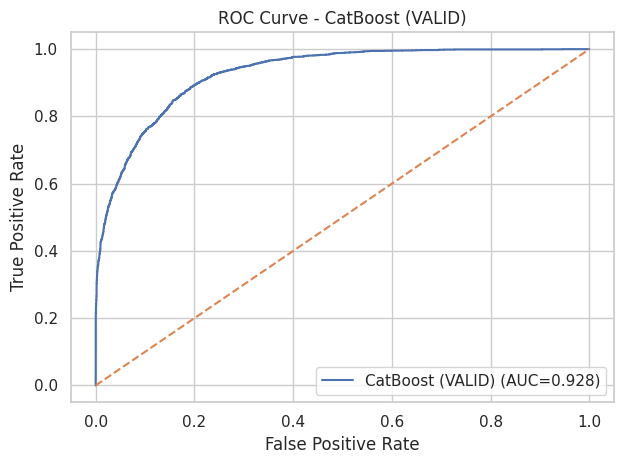

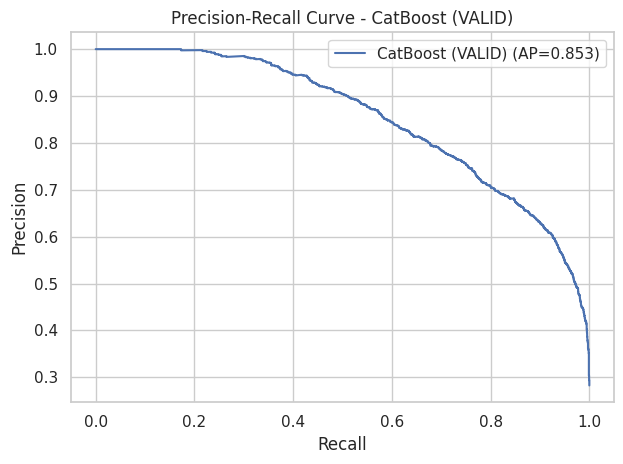

<Figure size 640x480 with 0 Axes>

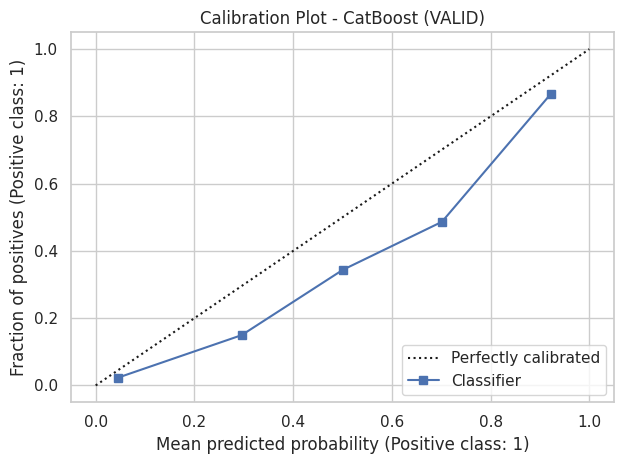

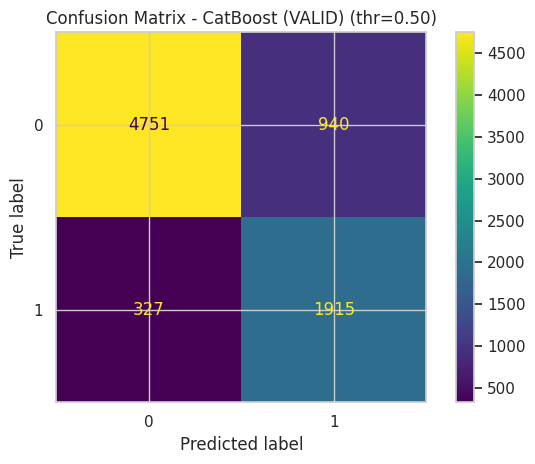

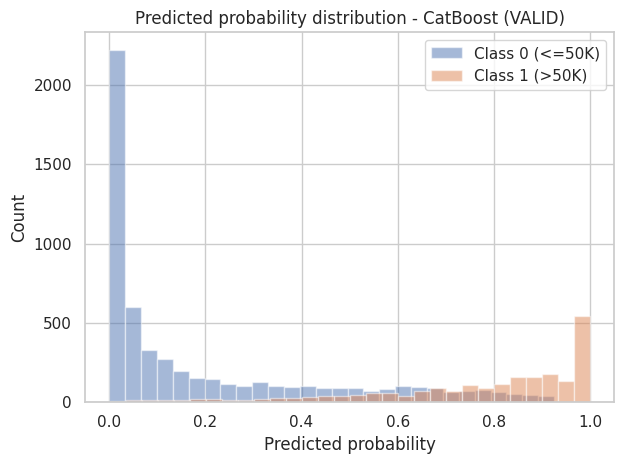

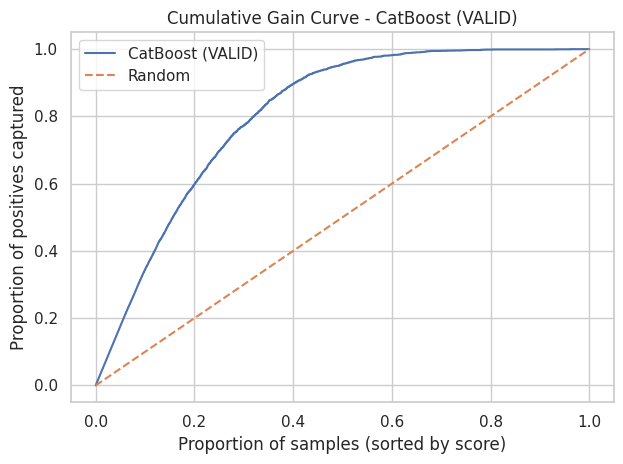

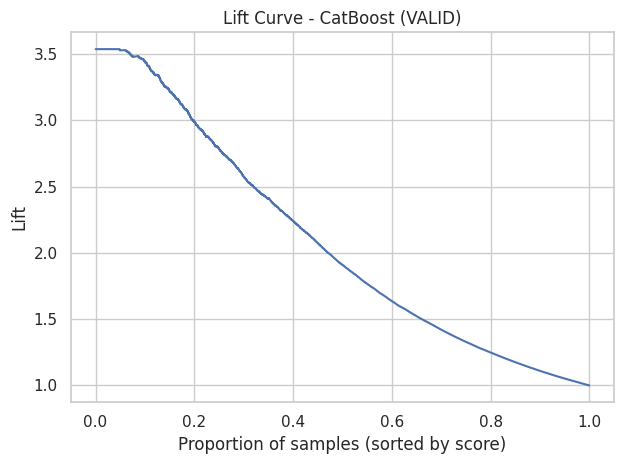

==== CatBoost (TEST): global metrics (threshold=0.50) ====
ROC AUC         : 0.9289
Average Precision (PR AUC): 0.8535
Log Loss        : 0.3322
Brier Score     : 0.1088
MAE (prob vs y) : 0.2133
MAPE (positives): 0.2263

Accuracy        : 0.8349
Precision       : 0.6579
Recall          : 0.8657
F1-score        : 0.7476

Top-K precision / recall (how well we find high-income customers):
 Top  1% -> precision=1.0000, recall=0.0353
 Top  5% -> precision=0.9924, recall=0.1754
 Top 10% -> precision=0.9622, recall=0.3405
 Top 20% -> precision=0.8588, recall=0.6078



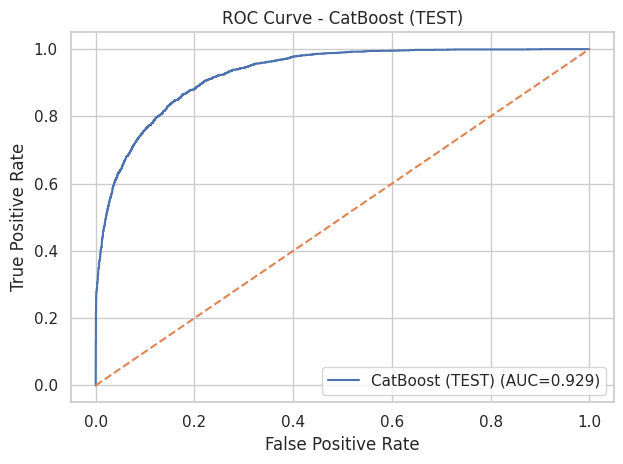

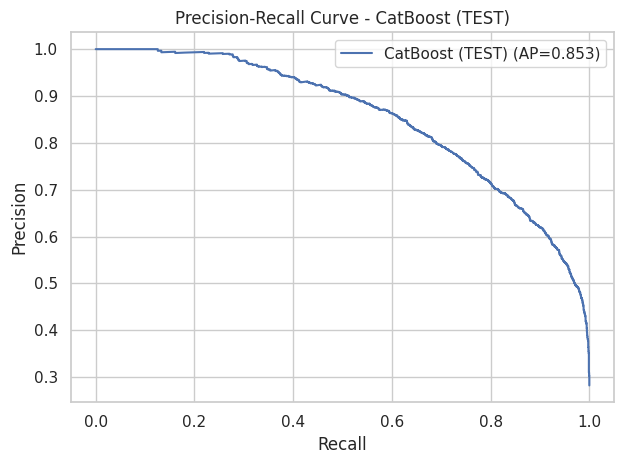

<Figure size 640x480 with 0 Axes>

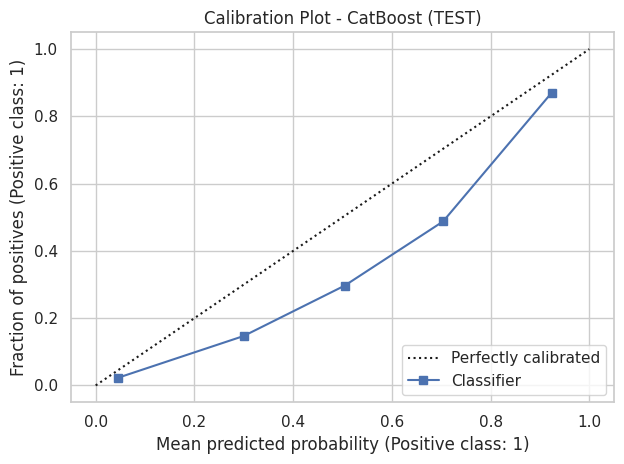

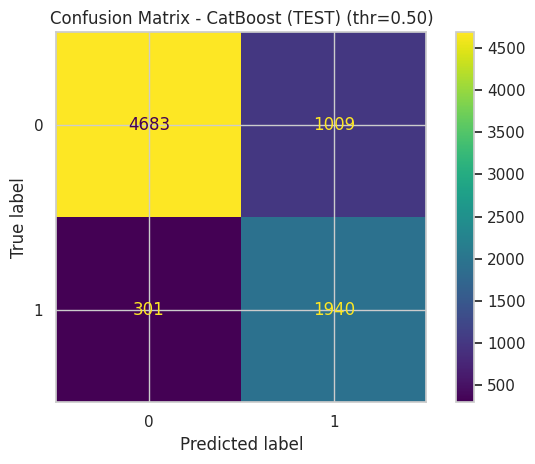

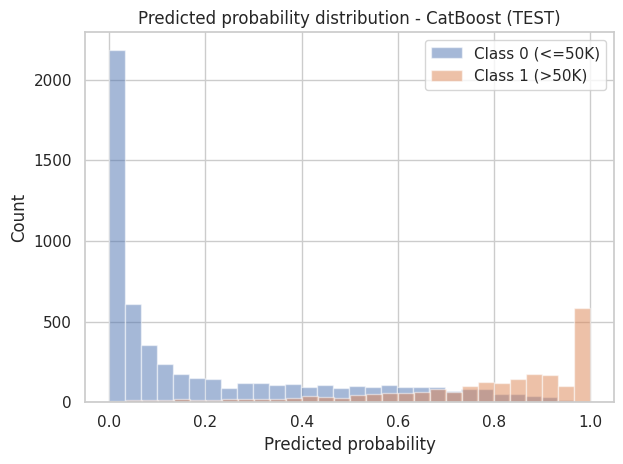

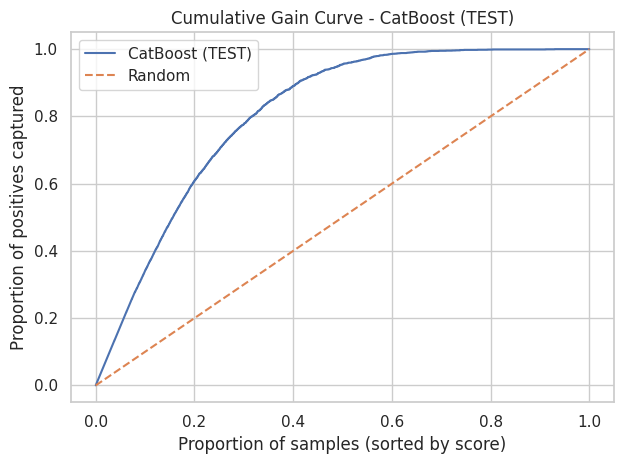

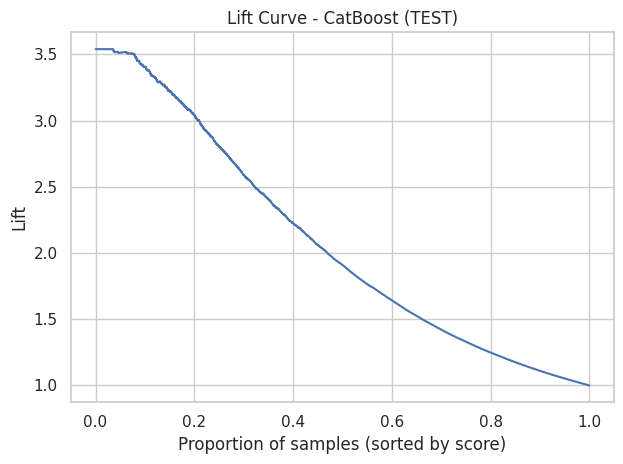

In [9]:

# Validation
y_valid_proba_cb = cat_model.predict_proba(valid_pool)[:, 1]
evaluate_classifier(y_valid, y_valid_proba_cb, model_name="CatBoost (VALID)", threshold=0.5)

# Test
y_test_proba_cb = cat_model.predict_proba(test_pool)[:, 1]
evaluate_classifier(y_test, y_test_proba_cb, model_name="CatBoost (TEST)", threshold=0.5)

In [10]:
# ======================================================
#  MODEL TRAINING + PRIOR-BASED CALIBRATION
# ======================================================

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# -----------------------
#  Target & features
# -----------------------
# df should contain all engineered features + 'income' + 'income_high'
target = "income_high"
X = df.drop(columns=[target, "income", "Name"], errors="ignore")
y = df[target]

# -----------------------
#  3-way split
# -----------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# -----------------------
#  Categorical feature indices
# -----------------------
cat_cols = X.select_dtypes(include=["object", "category"]).columns
cat_idx = [X.columns.get_loc(c) for c in cat_cols]

train_pool = Pool(X_train, y_train, cat_features=cat_idx)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_idx)

# -----------------------
#  Class-imbalance weight (balanced)
# -----------------------
pos_weight = float((len(y_train) - y_train.sum()) / y_train.sum())

# -----------------------
#  Priors: sample / effective model / bank
# -----------------------
pi_sample = y_train.mean()        # positive rate in labeled sample (~0.283)
w0, w1 = 1.0, pos_weight
pi_model = (w1 * pi_sample) / (w1 * pi_sample + w0 * (1 - pi_sample))  # effective prior (~0.5)

pi_bank = 2_000_000 / 21_000_000  # bank prior ≈ 0.095238

print(f"Sample positive rate        : {pi_sample:.3f}")
print(f"Effective model pos rate    : {pi_model:.3f}")
print(f"Bank expected positive rate : {pi_bank:.3f}")

def calibrate_to_bank_prior(p, pi_model=pi_model, pi_bank=pi_bank):
    """
    Prior-probability-shift calibration.
    p         : array-like of model probabilities P(Y=1 | x) under prior pi_model
    pi_model  : effective training prior seen by the model (after class_weights)
    pi_bank   : target prior (here, bank-wide 9.5%)
    returns   : calibrated probabilities under bank prior
    """
    p = np.asarray(p, dtype=float)
    eps = 1e-6
    p = np.clip(p, eps, 1 - eps)

    num = (pi_bank / pi_model) * p
    den = num + ((1 - pi_bank) / (1 - pi_model)) * (1 - p)
    p_cal = num / den
    return np.clip(p_cal, eps, 1 - eps)

# -----------------------
#  CatBoost model
# -----------------------
cat_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="PRAUC",        # PR AUC
    custom_loss=["AUC", "PRAUC"],
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    iterations=1500,
    class_weights=[1.0, pos_weight],
    random_seed=42,
    verbose=100,
    od_type="Iter",
    od_wait=100,
)

cat_model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

# -----------------------
#  Evaluation: raw vs calibrated
# -----------------------
# VALID
y_valid_proba_raw = cat_model.predict_proba(valid_pool)[:, 1]
y_valid_proba_cal = calibrate_to_bank_prior(y_valid_proba_raw)

print("\n=== VALIDATION ===")
print("VALID AUC (raw probs)        :", roc_auc_score(y_valid, y_valid_proba_raw))
print("VALID AUC (calibrated probs) :", roc_auc_score(y_valid, y_valid_proba_cal))

# TEST
y_test_proba_raw = cat_model.predict_proba(test_pool)[:, 1]
y_test_proba_cal = calibrate_to_bank_prior(y_test_proba_raw)

print("\n=== TEST ===")
print("TEST AUC (raw probs)         :", roc_auc_score(y_test, y_test_proba_raw))
print("TEST AUC (calibrated probs)  :", roc_auc_score(y_test, y_test_proba_cal))

# ======================================================
#  SCORING UNLABELED CUSTOMERS (OPTIONAL)
# ======================================================

# If you have df_target = customers with income NaN
if "df_target" in globals() and not df_target.empty:
    X_target = df_target.drop(columns=[target, "income", "Name"], errors="ignore")
    target_pool = Pool(X_target, cat_features=cat_idx)

    p_target_raw = cat_model.predict_proba(target_pool)[:, 1]
    p_target_cal = calibrate_to_bank_prior(p_target_raw)

    df_target_scored = df_target.copy()
    df_target_scored["p_wealthy_raw"]  = p_target_raw
    df_target_scored["p_wealthy_bank"] = p_target_cal

    # Example: sort by calibrated bank probability
    df_target_scored = df_target_scored.sort_values("p_wealthy_bank", ascending=False)

    # For the *real* 21M base you would now take top 2_000_000 rows.
    # Here it's just a demo on the subset.
    top_customers = df_target_scored.head(10)
    print("\nTop 10 unlabeled customers by calibrated P(>50K):")
    print(top_customers[["p_wealthy_bank"]].head(10))


Sample positive rate        : 0.283
Effective model pos rate    : 0.500
Bank expected positive rate : 0.095
0:	learn: 0.8792347	test: 0.8811298	best: 0.8811298 (0)	total: 61.3ms	remaining: 1m 31s
100:	learn: 0.9177606	test: 0.9173891	best: 0.9173891 (100)	total: 6.19s	remaining: 1m 25s
200:	learn: 0.9244365	test: 0.9209822	best: 0.9209822 (200)	total: 12s	remaining: 1m 17s
300:	learn: 0.9295245	test: 0.9231403	best: 0.9231403 (300)	total: 17.9s	remaining: 1m 11s
400:	learn: 0.9333937	test: 0.9245029	best: 0.9245192 (396)	total: 23.9s	remaining: 1m 5s
500:	learn: 0.9367384	test: 0.9261552	best: 0.9261552 (500)	total: 30.1s	remaining: 1m
600:	learn: 0.9389094	test: 0.9268784	best: 0.9268936 (587)	total: 36.2s	remaining: 54.1s
700:	learn: 0.9408940	test: 0.9273115	best: 0.9273134 (699)	total: 42.2s	remaining: 48.1s
800:	learn: 0.9427596	test: 0.9274732	best: 0.9274991 (796)	total: 48.4s	remaining: 42.2s
900:	learn: 0.9443502	test: 0.9275963	best: 0.9275963 (900)	total: 54.5s	remaining: 36


================ VALID SET ================
True positive rate in data (y):            0.2826
Mean raw probability:                     0.3610
Mean bank-calibrated probability P_bank:  0.1597
ROC AUC (raw probs)             : 0.9286
PR  AUC (raw probs)             : 0.8530
Brier score (raw probs)         : 0.1068
Brier score (bank-calibrated)   : 0.1266


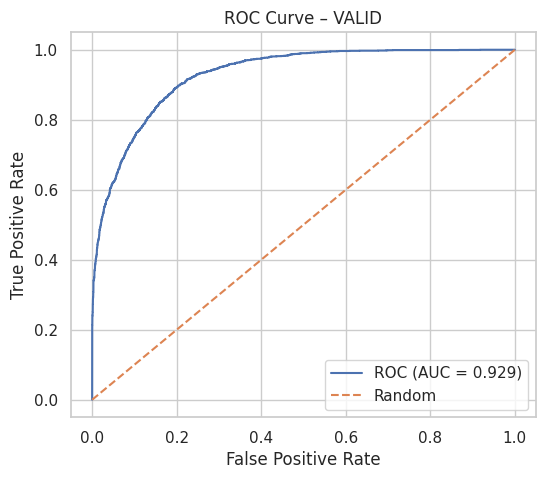

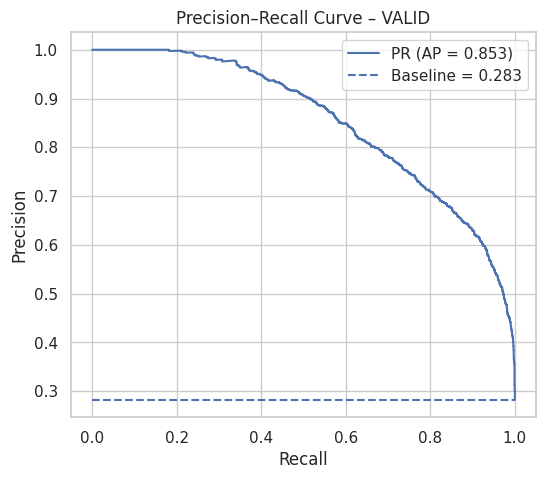

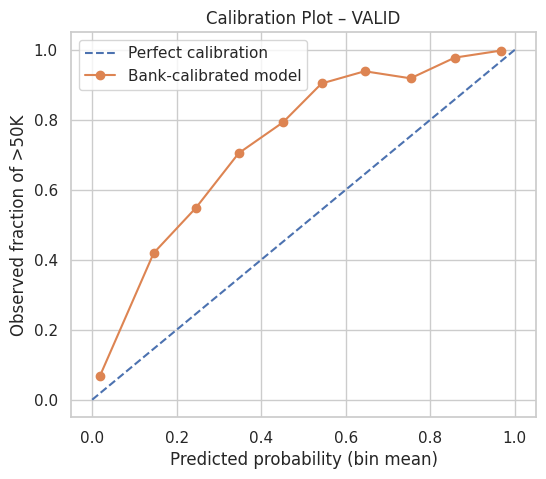

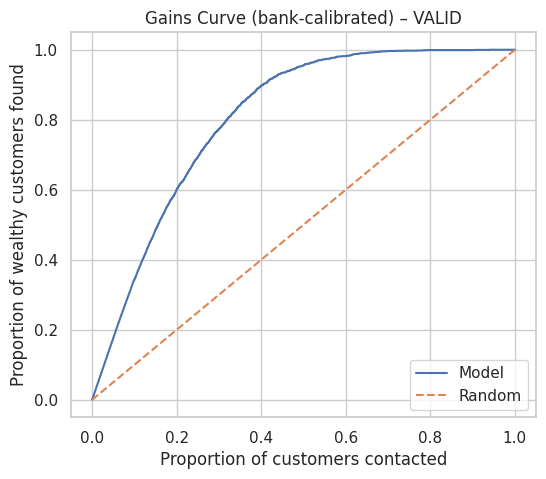


================ TEST SET ================
True positive rate in data (y):            0.2825
Mean raw probability:                     0.3674
Mean bank-calibrated probability P_bank:  0.1640
ROC AUC (raw probs)             : 0.9290
PR  AUC (raw probs)             : 0.8538
Brier score (raw probs)         : 0.1085
Brier score (bank-calibrated)   : 0.1245


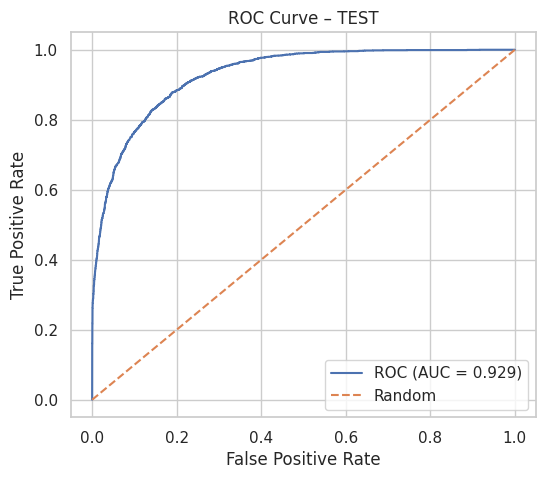

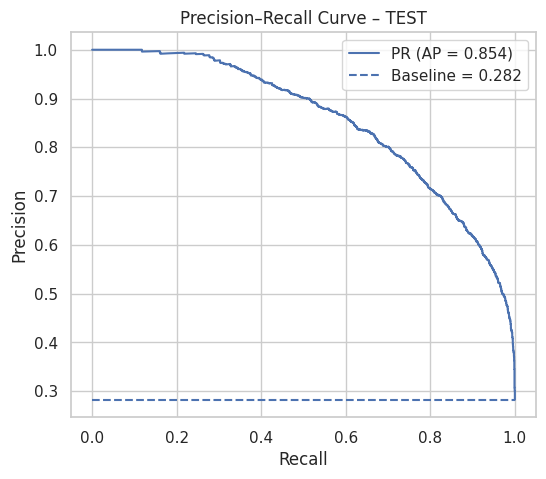

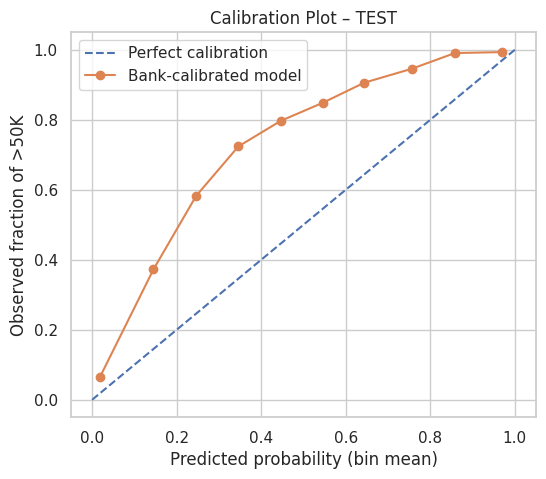

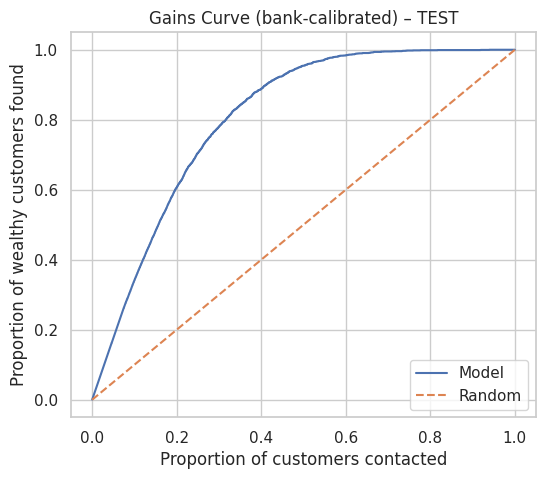

In [11]:


# ======================================================
#  PERFORMANCE METRICS & GRAPHS
# ======================================================

def evaluate_and_plot(y_true, p_raw, p_bank, dataset_name="VALID"):
    """
    y_true  : true labels (0/1)
    p_raw   : raw model probs (under model prior)
    p_bank  : probs calibrated to bank prior (~9.5% wealthy)
    """
    y_true = np.asarray(y_true)
    p_raw  = np.asarray(p_raw, dtype=float)
    p_bank = np.asarray(p_bank, dtype=float)

    base_rate = y_true.mean()

    print(f"\n================ {dataset_name} SET ================")
    print(f"True positive rate in data (y):            {base_rate:.4f}")
    print(f"Mean raw probability:                     {p_raw.mean():.4f}")
    print(f"Mean bank-calibrated probability P_bank:  {p_bank.mean():.4f}")

    # --- Scalar metrics ---
    roc_auc  = roc_auc_score(y_true, p_raw)
    pr_auc   = average_precision_score(y_true, p_raw)
    brier_raw  = brier_score_loss(y_true, p_raw)
    brier_bank = brier_score_loss(y_true, p_bank)

    print(f"ROC AUC (raw probs)             : {roc_auc:.4f}")
    print(f"PR  AUC (raw probs)             : {pr_auc:.4f}")
    print(f"Brier score (raw probs)         : {brier_raw:.4f}")
    print(f"Brier score (bank-calibrated)   : {brier_bank:.4f}")

    # ----------------------------------------------------
    # 1) ROC curve (raw probabilities)
    # ----------------------------------------------------
    fpr, tpr, _ = roc_curve(y_true, p_raw)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {dataset_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # ----------------------------------------------------
    # 2) Precision–Recall curve (raw probabilities)
    # ----------------------------------------------------
    precision, recall, _ = precision_recall_curve(y_true, p_raw)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision,
             label=f"PR (AP = {pr_auc:.3f})")
    plt.hlines(base_rate, 0, 1, linestyles="--",
               label=f"Baseline = {base_rate:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve – {dataset_name}")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

    # ----------------------------------------------------
    # 3) Calibration / Reliability curve (bank-calibrated)
    # ----------------------------------------------------
    n_bins = 10
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(p_bank, bins) - 1  # 0 .. n_bins-1

    mean_pred = []
    frac_pos  = []

    for b in range(n_bins):
        mask = bin_ids == b
        if np.any(mask):
            mean_pred.append(p_bank[mask].mean())
            frac_pos.append(y_true[mask].mean())
        else:
            mean_pred.append(np.nan)
            frac_pos.append(np.nan)

    mean_pred = np.array(mean_pred)
    frac_pos  = np.array(frac_pos)

    valid_bins = ~np.isnan(mean_pred)
    mean_pred = mean_pred[valid_bins]
    frac_pos  = frac_pos[valid_bins]

    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
    plt.plot(mean_pred, frac_pos, marker="o", label="Bank-calibrated model")
    plt.xlabel("Predicted probability (bin mean)")
    plt.ylabel("Observed fraction of >50K")
    plt.title(f"Calibration Plot – {dataset_name}")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

    # ----------------------------------------------------
    # 4) Gains / Lift curve (bank-calibrated)
    # ----------------------------------------------------
    order = np.argsort(p_bank)[::-1]
    y_sorted = y_true[order]

    cum_positives = np.cumsum(y_sorted)
    total_positives = cum_positives[-1]

    perc_customers = np.arange(1, len(y_sorted) + 1) / len(y_sorted)
    perc_positives = cum_positives / total_positives

    plt.figure(figsize=(6, 5))
    plt.plot(perc_customers, perc_positives, label="Model")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("Proportion of customers contacted")
    plt.ylabel("Proportion of wealthy customers found")
    plt.title(f"Gains Curve (bank-calibrated) – {dataset_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# ======================================================
#  RUN EVALUATION FOR VALID & TEST
# ======================================================

evaluate_and_plot(y_valid, y_valid_proba_raw, y_valid_proba_cal, dataset_name="VALID")
evaluate_and_plot(y_test,  y_test_proba_raw,  y_test_proba_cal,  dataset_name="TEST")


In [12]:

# 1) Use the same feature set and order as in training
feature_cols = X.columns  # X came from: X = df.drop([...])

X_target = df_target[feature_cols].copy()

# 2) Build CatBoost Pool with the same categorical indices
target_pool = Pool(X_target, cat_features=cat_idx)

# 3) Raw probabilities from the trained model (sample / model world)
df_target["p_gt50k_raw"] = cat_model.predict_proba(target_pool)[:, 1]

# 4) Calibrate to bank prior (~9.5% wealthy)
#    If your function is called adjust_for_prior_shift, just swap the name here.
df_target["p_gt50k_bank"] = calibrate_to_bank_prior(df_target["p_gt50k_raw"].values)


No objects info loaded


In [13]:
def top_k_expected(p, k_list=[0.05, 0.10, 0.20]):
    """
    p      : array-like of probabilities (may contain NaNs)
    k_list : list of fractions (e.g. [0.05, 0.10, 0.20])
    """
    p = np.asarray(p, dtype=float)

    # drop NaNs for ranking & mean
    p_valid = p[~np.isnan(p)]
    n = len(p_valid)

    if n == 0:
        print("No non-null probabilities to score.")
        return

    base_expected_rate = p_valid.mean()
    print(f"\nBase expected wealthy rate (non-null): {base_expected_rate:.3f}")
    print(f"Total customers with non-null prob: {n}")

    order = np.argsort(p_valid)[::-1]
    p_sorted = p_valid[order]

    for k in k_list:
        m = max(1, int(n * k))
        top = p_sorted[:m]
        expected_wealthy = top.sum()
        expected_rate = expected_wealthy / m

        print(
            f"Top {int(k*100)}% (n={m}): "
            f"expected wealthy ~ {expected_wealthy:.1f} "
            f"({expected_rate:.3f} rate)"
        )
# Combine probabilities: prefer bank-calibrated, fallback to raw
df_target["p_for_sort"] = np.where(
    df_target["p_gt50k_bank"].notna(),
    df_target["p_gt50k_bank"],
    df_target["p_gt50k_raw"]
)

# usage
top_k_expected(df_target["p_for_sort"].values, k_list=[0.05, 0.10, 0.20])


No non-null probabilities to score.
